# Assignment: classification based on 2D features (Spectrogram, MFCC)
### Jan Robert Eljasiak
### Master’s Degree in Data Science (A.Y. 2024/2025)

In [23]:
# Import necessary libraries
import os
from time import time

import matplotlib.pyplot as plt
import numpy as np
# Frequency analysis
from librosa import load
from librosa.feature import melspectrogram, mfcc
from librosa.util import fix_length
# Classification tools
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

## Data loading and evalution functions

In [24]:
# Placecholder for feature extractor
def identity(input):
    return input


# Data loader
def load_data(feature_extractor=identity, normalize=True):
    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            y, sr = load(os.path.join("./recordings", f))
            cur_features = feature_extractor(y, sr)
            features.append(cur_features)

            # Classes
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps) / (X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps) / (X_train_std + eps)]

    return X_train, X_test, y_train, y_test

In [25]:
# Function to evaluate classification performance
def evaluation(feature_extractor):
    """
    Evaluates a classification model using the given feature extractor.

    Args:
        feature_extractor (function): Feature extraction function.
    
    Prints:
        - Best hyperparameters from grid search
        - Classification report
        - Confusion matrix
    """

    # Data loading
    X_train, X_test, y_train, y_test = load_data(feature_extractor=feature_extractor)

    # Parameters to be tested in cross-validation
    param_grid = {'C': [100, 500, 1000],
                  'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

    # Support Vector Machine initialization
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

    # Training
    t0 = time()
    clf = clf.fit(X_train, y_train)
    print('Training completed in %0.3fs' % (time() - t0))

    # Result of the cross validation for parameters selection
    print('Best parameters combination:')
    print(' C: ' + str(clf.best_estimator_.C))
    print(' gamma: ' + str(clf.best_estimator_.gamma))

    # Make predictions
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Classification report
    print('Classification report:')
    print(classification_report(y_pred, y_test))

    # Confusion matrix
    print('Confusion matrix:')
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.xlabel("Prediction")
    plt.ylabel("Actual")

# Temporal/Frequency features (spectrogram)

Training completed in 13.203s
Best parameters combination:
 C: 1000
 gamma: 0.005
Classification report:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        12
           1       0.80      0.62      0.70        13
           2       0.80      0.80      0.80        15
           3       0.79      0.79      0.79        19
           4       0.82      0.28      0.42        32
           5       0.71      0.83      0.77        12
           6       0.71      0.59      0.65        17
           7       0.58      0.92      0.71        12
           8       0.41      0.88      0.56         8
           9       0.50      0.70      0.58        10

    accuracy                           0.67       150
   macro avg       0.68      0.74      0.68       150
weighted avg       0.72      0.67      0.66       150

Confusion matrix:
[[12  0  0  1  3  1  0  0  0  0]
 [ 0  8  0  0  2  0  0  0  0  0]
 [ 0  0 12  0  1  0  2  0  0  0]
 [ 0  0  2 15  0  0

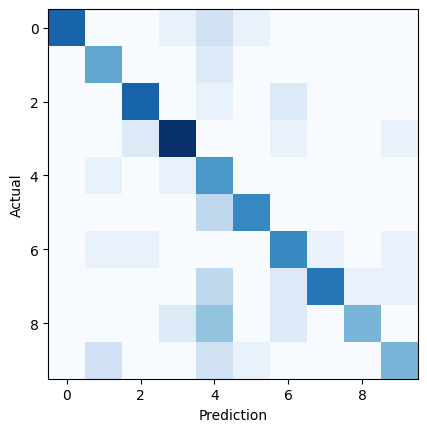

In [26]:
def feats_spectrogram(y, sr, tsize=10):
    """
    Extracts a Mel spectrogram feature, resizes it, and flattens it into a 1D vector.

    Args:
        y (array): Audio time-series.
        sr (int): Sampling rate.
        tsize (int): Target size for time axis.

    Returns:
        1D NumPy array of the spectrogram features.
    """
    # Extract the 2-dimensional feature
    mel = melspectrogram(y=y, sr=sr)
    # Force the feature to have fixed size
    mel_resized = fix_length(mel, size=tsize, axis=1, mode="edge")
    # Unroll the 2-dimensional feature into a 1-dimensional vector
    return mel_resized.flatten()


# Evaluate classification using spectrogram features
evaluation(feature_extractor=feats_spectrogram)

The model using Mel spectrogram feature correctly classifies about two-thirds of the test samples. Digits 4, 6, 9 seem to have a higher misclassification rate.

# Cepstral Features (MFCC)

Training completed in 2.945s
Best parameters combination:
 C: 100
 gamma: 0.005
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        14
           7       1.00      1.00      1.00        19
           8       1.00      1.00      1.00        17
           9       1.00      1.00      1.00        14

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150

Confusion matrix:
[[17  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0 15  0  0  0  0  0  0  0]
 [ 0  0  0 19  0  0  

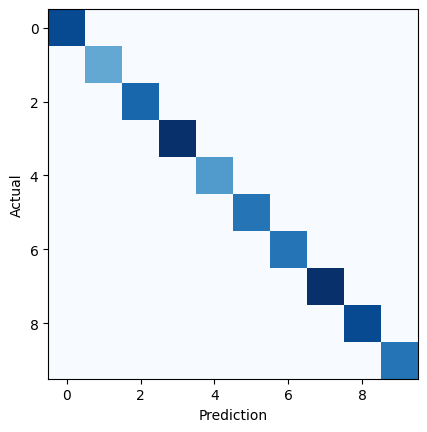

In [28]:
def feats_mfcc(y, sr, tsize=10):
    """
    Extracts MFCC features, resizes them, and flattens them into a 1D vector.

    Args:
        y (array): Audio time-series.
        sr (int): Sampling rate.
        tsize (int): Target size for time axis.

    Returns:
        1D NumPy array of the MFCC features.
    """
    # Extract the 2-dimensional feature
    cepstral = mfcc(y=y, sr=sr)
    # Force the feature to have fixed size
    mfcc_resized = fix_length(cepstral, size=tsize, axis=1, mode='edge')
    # Unroll the 2-dimensional feature into a 1-dimensional vector
    return mfcc_resized.flatten()


# Evaluate classification using MFCC features
evaluation(feature_extractor=feats_mfcc)

The model based on MFCC features correctly classifies all the digits.